# GPT-4o model with Azure OpenAI
<img src="https://th.bing.com/th/id/OIF.8JvEaIHUkXT7bREnLizwHQ?rs=1&pid=ImgDetMain">

> Documentation: https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#gpt-4o-and-gpt-4-turbo

In [1]:
import base64
import datetime
import glob
import gradio as gr
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image

In [2]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [3]:
check_openai_version()

Installed OpenAI version: 1.20.0
[OK] OpenAI version 1.20.0 is >= 1.0.0


In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 28-May-2024 12:29:19


In [5]:
print(f"Python version: {sys.version}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]


In [6]:
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 1.20.0


## Settings

In [7]:
load_dotenv("azure.env")

# Azure OpenAI
api_type: str = "azure"
api_key = os.getenv("OPENAI_API_KEY")
api_base = os.getenv("OPENAI_API_BASE")
api_version = "2024-05-01-preview"

In [8]:
# This is the deployed name of your GPT-4o model from the Azure Open AI studio
model = "gpt-4o"

## Testing the model

In [9]:
def gpt4o_text(prompt):
    """
    Gpt-4o model
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response

In [10]:
result = gpt4o_text("Who are you?")
print(result.choices[0].message.content)

I'm an AI assistant created to help you with information, tasks, and answering your questions. How can I assist you today?


In [11]:
result = gpt4o_text("What is the capital of France?")
print(result.choices[0].message.content)

The capital of France is Paris.


## Using an url image

In [12]:
def gpt4o_url(image_url, prompt):
    """
    Gpt-4o model using image url
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant to analyse images.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": image_url}},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response

In [13]:
image_url = "https://pbs.twimg.com/media/Cay-vlVW4AANslG?format=jpg&name=small"

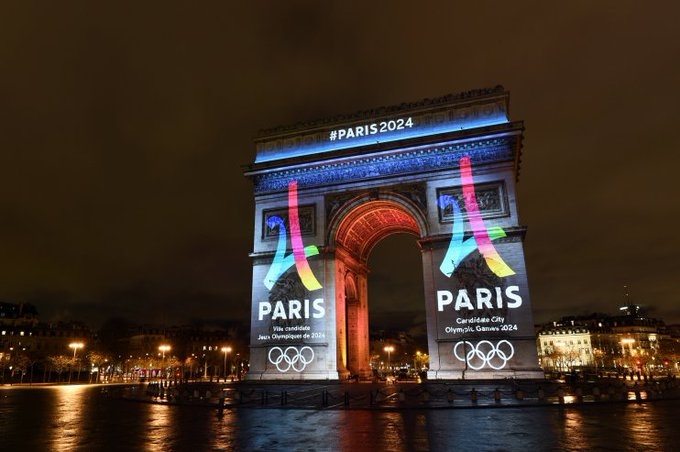

In [14]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img

In [15]:
result = gpt4o_url(image_url, "Analyse this image")

print(result.choices[0].message.content)

This image features the Arc de Triomphe in Paris, illuminated with a colorful projection. The projection includes the text "#PARIS2024" at the top, indicating support for Paris as a candidate city for the 2024 Olympic Games. The Olympic rings and a stylized ribbon-like logo are also part of the projection.

The image suggests a promotional event or campaign related to Paris's bid to host the 2024 Summer Olympics. The use of lighting and projection on an iconic landmark like the Arc de Triomphe highlights the city's enthusiasm and readiness to host the international sporting event. The scene is set at night, which enhances the visibility and impact of the light projections.


## Using an image file

In [16]:
def image_view(image_file):
    """
    View image using PIL
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(image_file)
        img = Image.open(image_file)
        display(img)

In [17]:
def local_image_to_data_url(image_path):
    """
    Get the url of a local image
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(
            
            image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [18]:
def gpt4o_imagefile(image_file, prompt):
    """
    Gpt-4o model
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant to analyse images.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": local_image_to_data_url(image_file)},
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response

## Example 1

image1.jpg


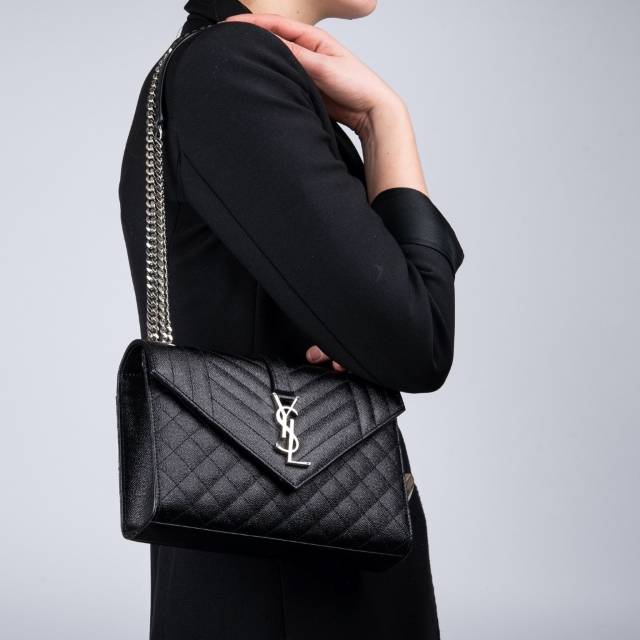

In [19]:
image_file = "image1.jpg"

image_view(image_file)

In [20]:
result = gpt4o_imagefile(
    image_file, "Extract the main article, its brand and its color."
)
print(result.choices[0].message.content)

The main article in the image is a handbag. The brand is Yves Saint Laurent (YSL), and its color is black.


In [21]:
context = """ 
You are a fashion expert, familiar with identifying features of fashion articles from images.
A user uploads an image and asks you to describe one particular piece in the shot: jacket, shoes, pants, \
watches, etc.
"""

prompt = """
You respond with your analysis of the following fields:

1. ITEM'S TYPE: Identify if it's a top, bottom, dress, outerwear, footwear, bag, jewelry...
2. BRAND: identity the brand of the item.
3. COLOR: Note the main color(s) and any secondary colors.
4. PATTERN: Identify any visible patterns such as stripes, florals, animal print, or geometric designs.\
Feel free to use any other patterns here.
5. MATERIAL: Best guess at the material that the item is made from.
6. FEATURES: Note any unique details or embellishments, like embroidery, sequins, studs, fringes, buttons,
zippers...
7. ITEM TYPE SPECIFIC: For each type of item, feel free to add any additional descriptions that are relevant \
to help describe the item. For example, for a jacket you can include the neck and sleeve design, plus the length.
8. MISC.: Anything else important that you notice.
9. SIZE: Print the size of the item if you get it from the image.
10. ITEM SUMMARY: Write a one line summary for this item.
11. ITEM CLASSIFICATION: Classify this item into CLOTHES, BAG, SHOES, WATCH or OTHERS.
12. ITEM TAGS: Generate 10 tags to describe this item. Each tags should be separated with a comma.
13. STORIES: Write multiple stories about this product in 5 lines.
14. TWEETER PUBLICATION: Write a tweeter ad for this item with some hashtags and emojis.
15. ECOMMERCE AD: Generate an item description for a publication on a ecommerce website with a selling message.
16. FRENCH ECOMMERCE AD: Generate an item description in French for a publication on a ecommerce website with \
a selling message.

The output should be a numbered bulleted list. Just print an empty line between each items starting at item 12.
"""

retailprompt = context + prompt

In [22]:
result = gpt4o_imagefile(image_file, retailprompt)
print(result.choices[0].message.content)

1. ITEM'S TYPE: Bag

2. BRAND: Saint Laurent (YSL)

3. COLOR: Main color is black, with silver hardware.

4. PATTERN: Quilted pattern.

5. MATERIAL: Leather

6. FEATURES: 
   - Silver chain strap
   - YSL logo in silver
   - Quilted texture
   - Envelope flap closure

7. ITEM TYPE SPECIFIC: 
   - Crossbody/shoulder bag
   - Medium size
   - V-shaped front flap

8. MISC.: The bag has a sophisticated and elegant design, suitable for both formal and casual occasions.

9. SIZE: Not specified

10. ITEM SUMMARY: A stylish and elegant Saint Laurent black leather quilted bag with silver hardware and a chain strap.

11. ITEM CLASSIFICATION: BAG

12. ITEM TAGS: Saint Laurent, YSL, bag, leather, black, quilted, chain strap, silver hardware, crossbody, luxury

   
13. STORIES:
   - Perfect for a night out, this Saint Laurent bag adds a touch of sophistication to any outfit.
   - Ideal for the modern fashionista, the YSL quilted bag combines elegance with practicality.
   - Elevate your everyday lo

## Example 2

image2.jpg


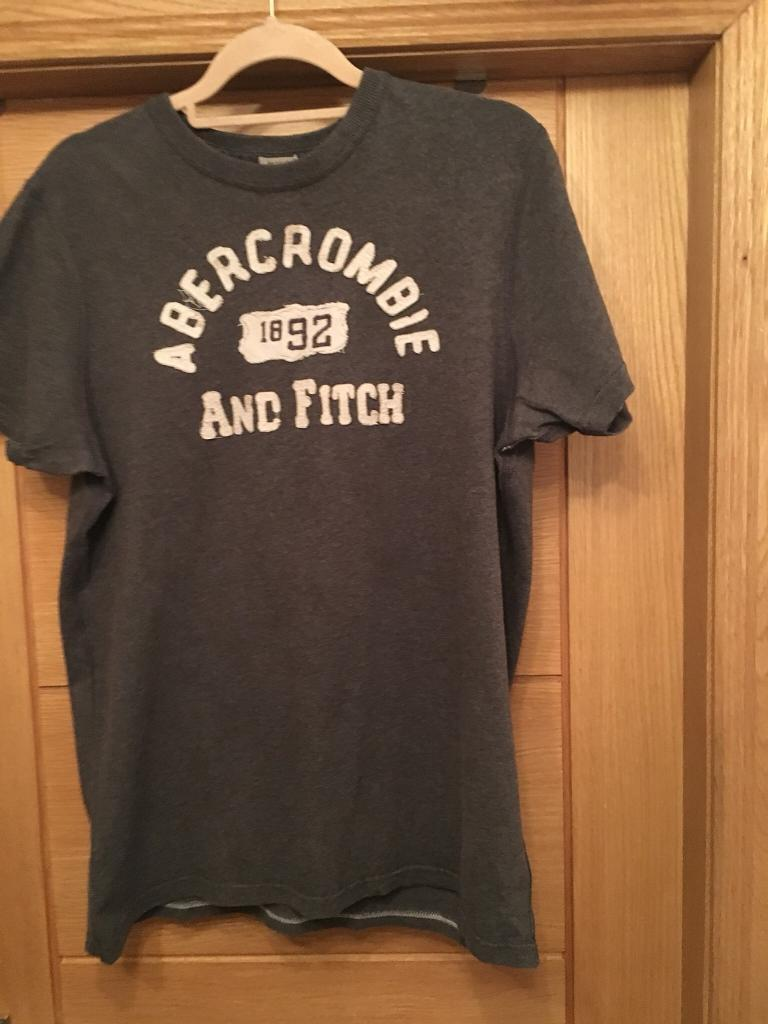

In [23]:
image_file = "image2.jpg"

image_view(image_file)

In [24]:
result = gpt4o_imagefile(image_file, "Extract the brand of the article")

print(result.choices[0].message.content)

The brand of the article is Abercrombie & Fitch.


In [25]:
result = gpt4o_imagefile(image_file, retailprompt)
print(result.choices[0].message.content)

1. ITEM'S TYPE: Top (T-shirt)

2. BRAND: Abercrombie & Fitch

3. COLOR: Main color is dark gray with white text.

4. PATTERN: Solid color with printed text.

5. MATERIAL: Likely cotton or a cotton blend.

6. FEATURES: Crew neck, short sleeves, printed brand name and "1892" on the front.

7. ITEM TYPE SPECIFIC: The T-shirt has a standard fit with a classic crew neck design and regular short sleeves.

8. MISC.: The T-shirt has a casual and relaxed style, suitable for everyday wear.

9. SIZE: Not specified in the image.

10. ITEM SUMMARY: Dark gray Abercrombie & Fitch T-shirt with white printed text.

11. ITEM CLASSIFICATION: CLOTHES

12. ITEM TAGS: Abercrombie, t-shirt, gray, casual, cotton, short sleeves, crew neck, printed text, everyday wear, relaxed fit

13. STORIES: 
    - This Abercrombie & Fitch T-shirt takes you back to the brand's roots with its vintage "1892" print.
    - Perfect for a casual day out, this dark gray T-shirt pairs effortlessly with jeans or shorts.
    - Crafted

## Example 3

image3.png


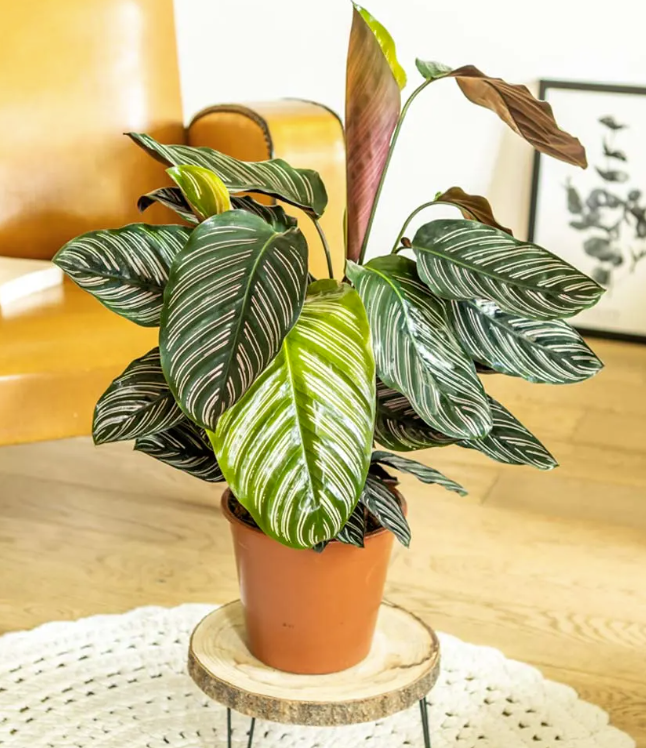

In [61]:
image_file = "image3.png"

image_view(image_file)

In [27]:
context = """
You are a plant and flowers expert, familiar with identifying plants and flowers from images.
A user uploads an image and asks you to describe one particular piece in the shot: flowers, plants...
"""

prompt = """
You respond with your analysis of the following fields:

1. ITEM'S TYPE: Identify the plant species.
2. COLOR: Note the main color(s) and any secondary colors of the plant.
3. COUNTRIES: Identify the country where this plant came from.
4. WATER: Identify the water preferences of this plant.
5. SUN: Identify the light preference of this plant.
6. TEMPERATURE: Identify the best temperature for this plant.
7. FERTILIZATION: What about fertilization?
8. DISEASE: What are the main diseases for this plant?
9. SOIL: What is the best soil?
10. SOIL PH: What is the best soil PH?
11. FLOWERING: What is the flowering period?
12. TOXICITY: What is the toxicity?
13. ITEM TYPE SPECIFIC: For each type of item, feel free to add any additional descriptions that are relevant \
to help describe the item.
14. MISC.: Anything else important that you notice about the plant.
15. SIZE: What is the usual size of this plant?
16. ITEM SUMMARY: Write a one-line summary for this item.
17. ITEM CLASSIFICATION: Classify this item into "plant for beginners", "plant that needs attention", \
"plant for experts".
18. ITEM TAGS: Generate 10 tags to describe this plant. Each tag should be separated with a comma.
19. STORIES: Write multiple stories about this plant in 5 lines.
20. TWEETER PUBLICATION: Write a tweeter ad for this plant with some hashtags and emojis.
21. ECOMMERCE AD: Generate a plant description for a publication on an ecommerce website with a selling message.
22. FRENCH ECOMMERCE AD: Generate a plant description in French for a publication on an ecommerce website with \
a selling message.

The output should be a numbered bulleted list.
"""

flower_prompt = context + prompt

In [28]:
result = gpt4o_imagefile(image_file, flower_prompt)
print(result.choices[0].message.content)

1. **ITEM'S TYPE:** Calathea ornata (Pinstripe Calathea)
2. **COLOR:** Main colors are dark green with pinkish-white stripes; undersides of leaves are purple.
3. **COUNTRIES:** Native to South America, particularly Brazil.
4. **WATER:** Prefers consistently moist soil; do not let it dry out.
5. **SUN:** Thrives in bright, indirect light; avoid direct sunlight.
6. **TEMPERATURE:** Ideal temperature range is 65-80°F (18-27°C).
7. **FERTILIZATION:** Fertilize monthly during the growing season (spring and summer) with a balanced, water-soluble fertilizer.
8. **DISEASE:** Prone to root rot if overwatered; can also be affected by spider mites, aphids, and mealybugs.
9. **SOIL:** Prefers well-draining, peat-based potting mix.
10. **SOIL PH:** Best in slightly acidic to neutral soil (pH 6.0-7.0).
11. **FLOWERING:** Rarely flowers indoors; when it does, it produces small, inconspicuous flowers.
12. **TOXICITY:** Non-toxic to pets and humans.
13. **ITEM TYPE SPECIFIC:** The striking leaf pattern

In [62]:
result = gpt4o_imagefile(image_file, flower_prompt + " Print the results in French")
print(result.choices[0].message.content)

1. TYPE D’ARTICLE : Calathea ornata (Plante à rayures roses).
2. COULEUR : Principalement verte avec des rayures blanches et roses.
3. PAYS : Originaire d'Amérique du Sud, notamment du Brésil.
4. EAU : Préfère un sol constamment humide, mais pas détrempé.
5. SOLEIL : Préfère une lumière indirecte modérée à faible.
6. TEMPÉRATURE : Idéalement entre 18°C et 24°C.
7. FERTILISATION : Fertiliser toutes les 2 à 4 semaines pendant la saison de croissance avec un engrais équilibré.
8. MALADIES : Sensible aux acariens, aux cochenilles et aux taches foliaires.
9. SOL : Sol bien drainé et riche en matière organique.
10. PH DU SOL : Légèrement acide, entre 6,1 et 6,5.
11. FLORESCENCE : Rare en intérieur, mais peut fleurir au printemps et en été.
12. TOXICITÉ : Non toxique pour les animaux domestiques.
13. TYPE D’ARTICLE SPÉCIFIQUE : Les feuilles peuvent se refermer la nuit, phénomène appelé "nyctinastie".
14. DIVERS : Nécessite une humidité élevée, idéalement autour de 60%.
15. TAILLE : Peut attei

## Example 4

In [ ]:
image_file = "image4.jpg"

image_view(image_file)

In [ ]:
result = gpt4o_imagefile(
    image_file, "Get the name, dob and the expiration date into a json file format"
)

print(result.choices[0].message.content)

In [ ]:
result = gpt4o_imagefile(
    image_file, "We are in May 2024. What is the age of this person?"
)

print(result.choices[0].message.content)

In [ ]:
result = gpt4o_imagefile(image_file, "What is the country?")

print(result.choices[0].message.content)

In [ ]:
result = gpt4o_imagefile(
    image_file, "Classify this into PASSPORT, DRIVER LICENCE, ID, TRANSPORTATION CARD"
)

print(result.choices[0].message.content)

## Example 5

In [ ]:
image_file = "image5.jpg"

image_view(image_file)

In [ ]:
result = gpt4o_imagefile(image_file, "What is the name and the email?")

print(result.choices[0].message.content)

## Example 6

image6.png


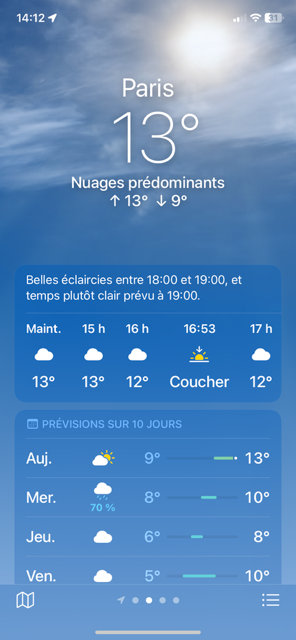

In [30]:
image_file = "image6.png"

image_view(image_file)

In [31]:
result = gpt4o_imagefile(
    image_file, "What is the time and the percentage of available memory?"
)

print(result.choices[0].message.content)

The time shown in the image is 14:12 (2:12 PM). The percentage of available memory is 31%, as indicated by the icon in the top right corner of the image.


In [33]:
result = gpt4o_imagefile(
    image_file, "Any rain during the week?")
print(result.choices[0].message.content)

Yes, according to the weather forecast, there is a 70% chance of rain on Wednesday ("Mer."). The other days in the week do not show a significant chance of rain.


## Example 7

image7.jpg


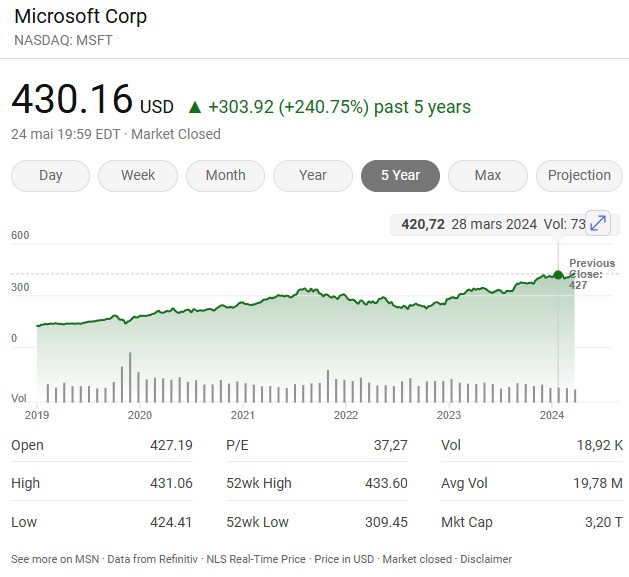

In [34]:
image_file = "image7.jpg"

image_view(image_file)

In [35]:
result = gpt4o_imagefile(image_file, "Describe this")

print(result.choices[0].message.content)

This is a stock performance summary for Microsoft Corporation (NASDAQ: MSFT), focusing on a 5-year period. 

### Key Data:
- **Current Stock Price**: $430.16 USD
- **Change**: +$303.92 (+240.75%) over the past 5 years
- **Date and Time**: 24 May at 19:59 EDT (Market Closed)

### Chart and Graph:
- The graph shows the stock price trend over the last 5 years. It indicates a general upward trend with some fluctuations.
- The highest point in the graph appears around early 2024.

### Specific Metrics:
- **Open**: $427.19
- **High**: $431.06
- **Low**: $424.41
- **P/E Ratio**: 37.27
- **Volume**: 18.92K
- **52 Week High**: $433.60
- **52 Week Low**: $309.45
- **Market Cap**: $3.20T

### Volume:
- The bar graph at the bottom shows the trading volume over the 5-year period, with spikes indicating higher trading activity.

### Additional Information:
- The chart includes options to view data by day, week, month, year, and maximum time periods.
- The previous closing price is indicated at $427.

In [36]:
result = gpt4o_imagefile(
    image_file, "You are a financial analyst. What is your report on this stock?"
)

print(result.choices[0].message.content)

### Financial Analysis Report: Microsoft Corp (NASDAQ: MSFT)

#### Current Overview
- **Current Price**: $430.16
- **Price Change (5 Years)**: +$303.92 (+240.75%)
- **Market Capitalization**: $3.20 Trillion
- **Price-Earnings (P/E) Ratio**: 37.27

#### Performance Metrics
- **52-Week High**: $433.60
- **52-Week Low**: $309.45
- **Opening Price**: $427.19
- **Daily High**: $431.06
- **Daily Low**: $424.41
- **Volume**: 18.92K
- **Average Volume**: 19.78M

#### Historical Performance
The stock has shown significant growth over the past five years, increasing by 240.75%. This indicates strong performance and investor confidence. The price trend over these five years shows a steady increase with some periods of consolidation and minor corrections. The stock has recently reached a new high, suggesting continued optimism in the market.

#### Valuation
The P/E ratio of 37.27 is relatively high, which could indicate that the stock is overvalued compared to its earnings. However, it may also re

## Example 8

image8.png


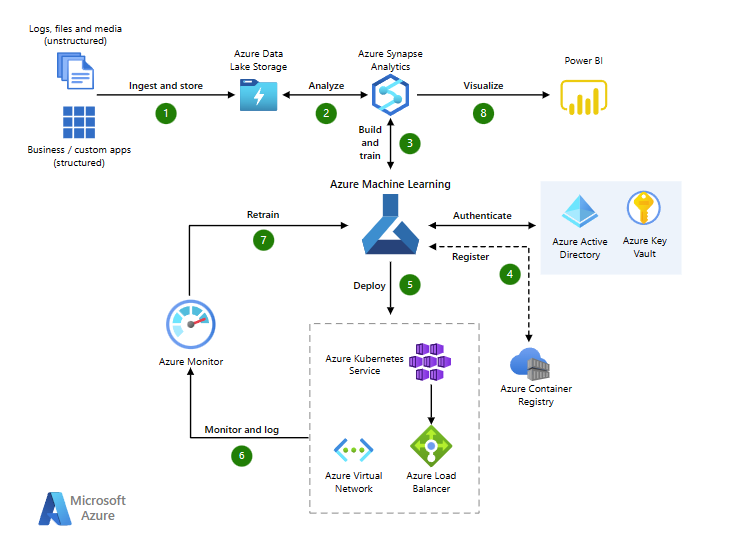

In [37]:
image_file = "image8.png"

image_view(image_file)

In [38]:
result = gpt4o_imagefile(image_file, "Describe this")

print(result.choices[0].message.content)

This diagram illustrates a data processing and machine learning workflow using Microsoft Azure services. Here is a step-by-step description:

1. **Ingest and Store Data**:
   - Data is ingested and stored from various sources, such as logs, files, and media (unstructured data) and business/custom apps (structured data) into Azure Data Lake Storage.

2. **Analyze Data**:
   - The stored data is then analyzed using Azure Synapse Analytics.

3. **Build and Train Models**:
   - The analyzed data is used to build and train machine learning models with Azure Machine Learning.

4. **Register and Authenticate**:
   - The machine learning models are registered and authenticated using Azure Active Directory and Azure Key Vault.

5. **Deploy Models**:
   - The trained models are deployed using Azure Kubernetes Service (AKS), which includes components like Azure Virtual Network and Azure Load Balancer to manage the infrastructure.

6. **Monitor and Log**:
   - The deployed models and services are 

In [39]:
result = gpt4o_imagefile(
    image_file,
    "List the Azure technologies I need to provision into my Azure subscription.",
)

print(result.choices[0].message.content)

Based on the provided diagram, here are the Azure technologies you need to provision into your Azure subscription:

1. **Azure Data Lake Storage** - For ingesting and storing data.
2. **Azure Synapse Analytics** - To analyze data and build/train models.
3. **Azure Machine Learning** - For machine learning tasks like building, training, deploying, and retraining models.
4. **Azure Active Directory** - For authentication and securing access.
5. **Azure Key Vault** - To manage secrets and keys securely.
6. **Azure Kubernetes Service (AKS)** - For container orchestration.
7. **Azure Container Registry** - To store and manage container images.
8. **Azure Virtual Network** - To provide network connectivity for your services.
9. **Azure Load Balancer** - To distribute network traffic evenly across your services.
10. **Azure Monitor** - To monitor and log the performance of your services.
11. **Power BI** - For data visualization and business intelligence.

These services work together to crea

## Image 9

image9.jpg


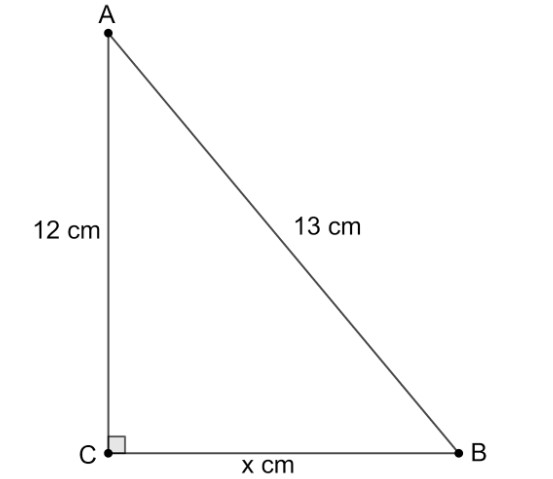

In [40]:
image_file = "image9.jpg"

image_view(image_file)

In [41]:
result = gpt4o_imagefile(image_file, "What is the dimension of the line CB?")

print(result.choices[0].message.content)

The triangle shown is a right triangle with \( \angle ACB \) being the right angle. To find the length of line CB (denoted as \( x \)), we can use the Pythagorean theorem, which states:

\[ a^2 + b^2 = c^2 \]

Here, \( a = 12 \) cm, \( b = x \) cm, and \( c = 13 \) cm. Plugging in the values, we get:

\[ 12^2 + x^2 = 13^2 \]

\[ 144 + x^2 = 169 \]

Subtract 144 from both sides:

\[ x^2 = 25 \]

Taking the square root of both sides:

\[ x = 5 \, \text{cm} \]

So, the dimension of line CB is 5 cm.


In [42]:
result = gpt4o_imagefile(image_file, "What is the angle between AC and CB")
print(result.choices[0].message.content)

The angle between AC and CB is 90 degrees. This is evident from the right-angle symbol at vertex C.


## Image 10

image10.png


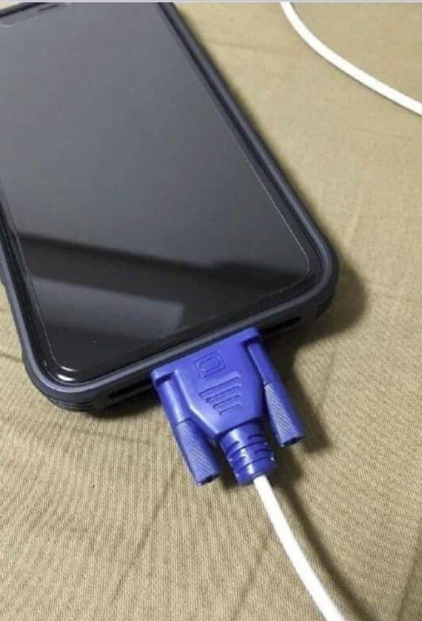

In [43]:
image_file = "image10.png"

image_view(image_file)

In [44]:
result = gpt4o_imagefile(image_file, "What's wrong here?")

print(result.choices[0].message.content)

This image shows a phone with a VGA connector seemingly plugged into it. VGA connectors are typically used for connecting video output to monitors and are not compatible with the ports found on phones. The correct cable for charging a phone or connecting it to other devices would usually be a USB type (such as Micro-USB, USB-C, or Lightning connector), not a VGA cable.


## Image 11

image11.jpg


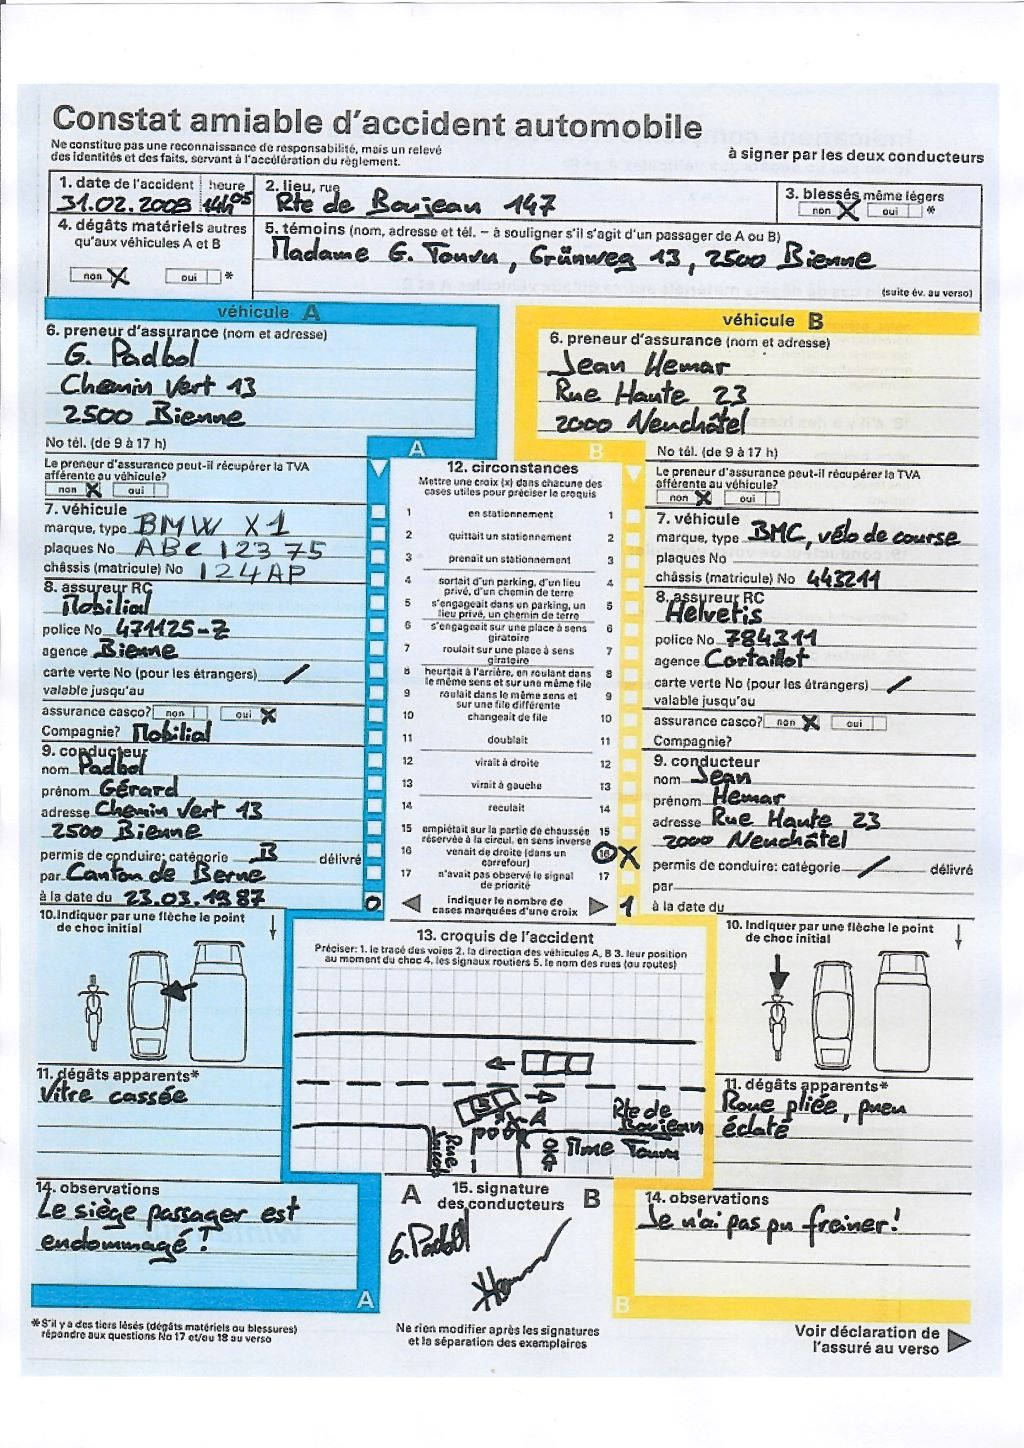

In [45]:
image_file = "image11.jpg"

image_view(image_file)

In [46]:
prompt = "Classify this document into 'Driver licence', 'Passport', 'European Accident form', 'Others'"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

This document falls under the category of 'European Accident form'.


In [47]:
prompt = "What is the language used in this document?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

The language used in this document is French.


In [48]:
prompt = "Generate a summary."

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

The document is a European Accident Statement form filled out in French after a car accident. 

- **Date and Time of Accident**: 31st February 2023, 16:47.
- **Location**: Rte de Beroieau 467.
- **Involved Parties**:
  - **Vehicle A**: 
    - Driver: Gérard Padbol
    - Address: Chemin Vert 13, 2500 Bienne
    - Vehicle: BMW X1, License Plate: ABC 123 75
    - Insurance: Tobilial, Policy No: 674725-7
    - Damage: Broken window, passenger seat damaged.
  - **Vehicle B**: 
    - Driver: Jean Hemar
    - Address: Rue Haute 23, 2000 Neuchâtel
    - Vehicle: BMC bicycle, License Plate: 443241
    - Insurance: Helvetis, Policy No: 784321
    - Damage: Bent wheel, punctured tire.
- **Witness**: Thadane E. Younu, Grumegg 43, 2500 Bienne.
- **Circumstances**: 
  - Vehicle A: Indicated as the vehicle that did not yield at a junction.
  - Vehicle B: Indicated as the vehicle coming from the right.
- **Sketch and Observations**: A sketch of the accident is provided showing the positions of the veh

In [49]:
prompt = "What are the names, cars models of vehicles A and B? Print the results in a json file format."

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

```json
{
  "vehicle_A": {
    "owner_name": "G. Padbol",
    "address": "Chemin Vert 13, 2500 Bienne",
    "car_model": "BMW X1",
    "license_plate": "ABC 123 75",
    "chassis_number": "124AP"
  },
  "vehicle_B": {
    "owner_name": "Jean Hemar",
    "address": "Rue Haute 23, 2000 Neuchatel",
    "car_model": "BMC, vélo de course",
    "license_plate": "No",
    "chassis_number": "443211"
  }
}
```


In [50]:
prompt = "Display some informations about the brand and model of the vehicle A."

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

The vehicle A in the document is described as follows:

- **Brand and Model**: BMW X1
- **License Plate**: ABC 123 75
- **Chassis (Matricule) No.**: 124AP
- **Insurance**: 
  - **Company**: Tobilial
  - **Policy No.**: 674725-7
  - **Agency**: Bienne

Additionally, the owner of the vehicle A is Gérard Padbol, residing at Chemin Vert 13, 2500 Bienne. The apparent damage to the vehicle includes a broken window, and there is a note indicating that the passenger seat is damaged.


In [51]:
prompt = "What are the damages for vehicles A and B?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

Based on the provided accident report, the damages for the vehicles involved are as follows:

- **Vehicle A:**
  - Apparent damages: "Vitres cassées" (broken windows)
  - Observations: "Le siège passager est endommagé" (the passenger seat is damaged)

- **Vehicle B:**
  - Apparent damages: "Roue pliée, pneu éclaté" (bent wheel, burst tire)
  - Observations: "Je n'ai pas pu freiner!" (I could not brake!)


In [52]:
prompt = "Do we have injured people?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

No, according to the document, there are no injured people. In section 3, which asks about injuries, the box for "non" (no) is checked.


In [53]:
prompt = "Do we have some witness?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

Yes, there is a witness mentioned in the form. The witness is listed under section 5 (témoins) with the details:

- Name: Thadane S. Tamou
- Address: Grange 43, 2500 Bienne

The witness's address and other details are provided in the designated section for witnesses.


In [54]:
prompt = "What are the main colors of this document?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

The main colors of the document are:

1. Blue
2. Yellow
3. Black
4. White

These colors are used to differentiate sections and highlight important information within the document.


In [55]:
prompt = "Explain the drawings from section number 10 for vehicles A and B"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

In section number 10 of the document, there are drawings representing the positions and orientations of vehicles A and B at the moment of the accident.

**Vehicle A:**
- Vehicle A is depicted as a car.
- It is shown moving straight forward.
- The drawing indicates that it collided with the rear of Vehicle B.

**Vehicle B:**
- Vehicle B is depicted as a bicycle.
- It is shown traveling in the same direction as Vehicle A.
- The collision appears to have occurred at the rear of the bicycle, suggesting that Vehicle A hit Vehicle B from behind.

These drawings provide a visual representation of how the accident occurred, highlighting the positions and directions of both vehicles at the point of impact.


In [56]:
prompt = "Explain the drawing from section number 13"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

Section number 13 of the document contains a drawing of the accident. This sketch provides a visual representation of how the accident occurred, showing the positions and directions of both vehicles involved.

Here is a detailed explanation of the drawing:

1. **Road Layout**: The drawing shows two parallel lanes, likely indicating a two-way street. 

2. **Vehicle Positions**:
   - **Vehicle A (BMW X1)**: This vehicle is illustrated as being in the right lane, moving forward.
   - **Vehicle B (BMC bicycle)**: This vehicle is depicted in front of Vehicle A, also in the right lane.

3. **Collision Point**: The drawing marks the collision point where Vehicle A seems to have impacted Vehicle B from behind.

4. **Additional Marks**: The sketch includes arrows showing the direction of both vehicles, indicating that both were traveling in the same direction on the same lane.

5. **Street Name**: The road is labeled as "Rte de Boujean," which provides context for where the accident took place.

In [58]:
prompt = "Do we have signatures on section 15? Just say YES or NO. IF the answer is YES, how many signatures do we have?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

YES, there are 2 signatures on section 15.


## WebApp

In [68]:
# Initialize the AzureOpenAI client once
client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{model}",
)


def gpt4o_webapp_fn(pil_image, prompt):
    """
    GPT-4 model integration for analyzing images.
    """

    # Save image to an in-memory buffer
    buffer = BytesIO()
    pil_image.save(buffer, format="JPEG")
    buffer.seek(0)

    # Encode the image to base64
    image_data = base64.b64encode(buffer.read()).decode('utf-8')
    image_url = f"data:image/jpeg;base64,{image_data}"

    # Construct the messages
    messages = [
        {"role": "system", "content": "You are a helpful assistant to analyse images."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": image_url}},
            ],
        },
    ]

    # Call the Azure OpenAI API
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=2000,
        temperature=0.0,
    )

    return response.choices[0].message.content


In [69]:
image_url = "https://th.bing.com/th/id/OIF.8JvEaIHUkXT7bREnLizwHQ?rs=1&pid=ImgDetMain"
logo = "<center> <img src= {} width=200px></center>".format(image_url)
title = "GPT-4o model with Azure OpenAI"

inputs = [
    gr.Image(type="pil", label="Your image"),
    gr.Text(label="Your prompt"),
]
outputs = [
    gr.Text(label="GPT-4o results"),
]
theme = "gradio/soft"  # https://huggingface.co/spaces/gradio/theme-gallery

gp4o_webapp = gr.Interface(
    fn=gpt4o_webapp_fn,
    inputs=inputs,
    outputs=outputs,
    description=logo,
    title=title,
    theme=theme,
)

gp4o_webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://2715b305549fb71166.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


> End